In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [2]:
import nibabel as nib
from nibabel.streamlines import load as load_trk
import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
from skimage.transform import resize
from scipy.ndimage.morphology import binary_dilation
import dipy.data as dpd
from sklearn.utils import class_weight
from sklearn.cross_validation import train_test_split

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

Using TensorFlow backend.


In [4]:
import bundlenet as bn

In [5]:
import dask.bag as db
import warnings
warnings.filterwarnings('ignore')

In [6]:
bundles80 = ['AR', 'CS','CST','CT','FPT','OPT','OR','PPT','TPT','AF','AST','C','EMC','IFOF','ILF', \
            'MdLF', 'SLF', 'UF', 'VOF']

In [7]:
bundle_files = []
for b in bundles80:
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/' + b + '_R.trk')
for b in bundles80:
    bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/' + b + '_L.trk')
bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/F_L_R.trk')
bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/CC_ForcepsMajor.trk')
bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/CC_ForcepsMinor.trk')
bundle_files.append('/home/ubuntu/Atlas_80_Bundles/bundles/CCMid.trk')
bundle_files = sorted(bundle_files)


In [6]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))

In [7]:
diff_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape=diff_img.shape[0:3]
vol_shape

(182, 218, 182)

In [8]:
bundle_files

['/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/AF_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CCMid.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMajor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CC_ForcepsMinor.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/CST_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/C_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IF0F_R.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/IFOF_L.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/MCP.trk',
 '/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/UF_L.trk',
 '/home/ubuntu/A

In [9]:
n_streamlines = []
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    streamlines = bn.read_sl(fname) 
    n_streamlines.append(len(streamlines))


In [10]:
np.min(n_streamlines), len(n_streamlines)

(72, 16)

In [11]:
take_n_bundles = len(n_streamlines)
take_n_sl = np.min(n_streamlines)

test_perc=0
val_perc=0.2
size_slimage = 100
dil_iters = 5

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


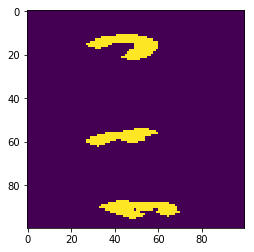

In [12]:
process_sl = 1

if process_sl == 1:
    streamlines_loaded = db.from_sequence(bundle_files).map(bn.read_sl_mni).compute()
    streamlines_processed = db.from_sequence(streamlines_loaded).map(bn.process_sl,take_n_sl,vol_shape,size_slimage,dil_iters).compute() 
    data_train, data_test, data_val, labels_train, labels_test, labels_val = bn.partition_testtrain(test_perc, val_perc, streamlines_processed)
    plt.imshow(streamlines_processed[0][1,:,:,0])

In [13]:
img_rows = size_slimage
img_cols = size_slimage
batch_size = 4
epochs = 16
num_classes = take_n_bundles
input_shape = (img_rows, img_cols,1)

In [ ]:
for dropout_factor in 0,0.25,0.5:
    for num_convlayers in 3, 4, 5:
        for num_fulllayers in 1, 2:
            class_weights = class_weight.compute_class_weight('balanced',np.unique(labels_train),labels_train)
            model = bn.buildmodel_specify(input_shape,num_classes,dropout_factor, num_convlayers, num_fulllayers)
            labels_train_cat = keras.utils.to_categorical(labels_train, num_classes)
            labels_val_cat  = keras.utils.to_categorical(labels_val, num_classes)
            filepath='checkpoints/weights.best' + str(num_classes) + '.hdf5'
            checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
            callbacks_list = [checkpoint]
            training = model.fit(data_train, labels_train_cat,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val_cat),
                     callbacks=callbacks_list,
                     class_weight=class_weights)
            model.save('savedmodel_nclasses'+ str(num_classes) + '_do' + str(dropout_factor) + '_nc' + str(num_convlayers) + '_fc' + str(num_fulllayers) +'.h5')
            fig = bn.plot_accuracy(training)

In [ ]:
fit_model = 0

if fit_model == 0:
    model = load_model('savedmodel'+ str(num_classes) +'.h5')
    model.load_weights('checkpoints/weights.best' + str(num_classes) + '.hdf5')
else:
    class_weights = class_weight.compute_class_weight('balanced',np.unique(labels_train),labels_train)
    model = bn.buildmodel(input_shape,num_classes)
    labels_train_cat = keras.utils.to_categorical(labels_train, num_classes)
    labels_val_cat  = keras.utils.to_categorical(labels_val, num_classes)
    filepath='checkpoints/weights.best' + str(num_classes) + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    training = model.fit(data_train, labels_train_cat,
                     batch_size=batch_size,
                     epochs=epochs,
                     verbose=1,
                     validation_data=(data_val, labels_val_cat),
                     callbacks=callbacks_list,
                     class_weight=class_weights)
    model.save('savedmodel'+ str(num_classes) +'.h5')
    fig = bn.plot_accuracy(training)

In [15]:
sub2_t1_img = nib.load('/home/ubuntu/MNI152_T1_1mm_brain.nii.gz')
vol_shape_subj2=sub2_t1_img.shape[0:3]
vol_shape_subj2

(182, 218, 182)

In [ ]:
# if op.exists('./streamlines_processed_100307.npz'):
#     loaded_from_file = np.load('streamlines_processed_100307.npz')
#     streamlines_all_processed_subj1 = loaded_from_file['processed_streamlines']
#     labels_selected_s1 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s1 = bn.read_sl_mni('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     map_files = sorted(glob('/home/ubuntu/recobundles/100307/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s1, labels_s1 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s1 = bn.getunlabeledstreamlines(len(streamlines_all_s1), labeled_index_s1, len(streamlines_all_s1)-len(labeled_index_s1), 0)
#     labels_selected_s1, streamlines_selected_s1 = bn.combinestreamlines(labeled_index_s1, unlabeled_index_s1, labels_s1, streamlines_all_s1)
#     streamlines_all_processed_subj1 = bn.process_sl(streamlines_selected_s1,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_100307',processed_streamlines = streamlines_all_processed_subj1, streamline_labels = labels_selected_s1)

In [17]:
num_classes=16
dropout_factor=0
num_convlayers=3
num_fulllayers=1
model = load_model('savedmodels/savedmodel_nclasses'+ str(num_classes) + '_do' + str(dropout_factor) + '_nc' + str(num_convlayers) + '_fc' + str(num_fulllayers) +'.h5')

In [ ]:
num_classes = 42
for subj in '973770','979984','983773','984472':
    if op.exists('./streamlines_processed' + subj + '_' + str(num_classes) + '.npz'):
        print(subj)
        #loaded_from_file = np.load('streamlines_processed' + subj + '_' + str(num_classes) + '.npz')
        #streamlines_all_processed_subj1 = loaded_from_file['processed_streamlines']
        #labels_selected_s1 = loaded_from_file['streamline_labels']
    else:
        print(subj)
        streamlines_all_s1 = bn.read_sl_mni('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/whole_brain_MNI_tracks_from_peaks__moved.trk') 
        map_files = []
        for b in bundles80:
            map_files.append('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_' + b + '_R__labels.npy')
        for b in bundles80:
            map_files.append('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_' + b + '_L__labels.npy')
        map_files.append('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_F_L_R__labels.npy')
        map_files.append('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_CC_ForcepsMajor__labels.npy')
        map_files.append('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_CC_ForcepsMinor__labels.npy')
        map_files.append('/home/ubuntu/copied80/sub-'+ subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_CCMid__labels.npy')
        map_files = sorted(map_files)    
        labeled_index_s1, labels_s1 = bn.getlabeledstreamlines(map_files)
        unlabeled_index_s1 = bn.getunlabeledstreamlines(len(streamlines_all_s1), labeled_index_s1, len(streamlines_all_s1)-len(labeled_index_s1), 0)
        labels_selected_s1, streamlines_selected_s1 = bn.combinestreamlines(labeled_index_s1, unlabeled_index_s1, labels_s1, streamlines_all_s1)
        streamlines_all_processed_subj1 = bn.process_sl(streamlines_selected_s1,-1,vol_shape_subj2,size_slimage,dil_iters)
        np.savez('streamlines_processed' + subj + '_' + str(num_classes) + '.npz',processed_streamlines = streamlines_all_processed_subj1, streamline_labels = labels_selected_s1)

973770
979984
983773
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [ ]:
np.max(unlabeled_index_s1)

In [ ]:
streamlines_all_s1 = bn.read_sl_mni('/home/ubuntu/copied16/sub-970764/sess-01/dwi/out_work/whole_brain_MNI_tracks_from_peaks__moved.trk') 

In [ ]:
len(streamlines_all_s1)

In [ ]:
num_classes = 16
for subj in '970764','970764','971160','972566','973770','978578','979984','983773','984472':
    if op.exists('./streamlines_processed_' + subj + '_' + str(num_classes) + '.npz'):
        print(subj)
        #loaded_from_file = np.load('streamlines_processed_' + subj + '_' + str(num_classes) + '.npz')
        #streamlines_all_processed_subj2 = loaded_from_file['processed_streamlines']
        #labels_selected_s2 = loaded_from_file['streamline_labels']
    else:
        streamlines_all_s2 = bn.read_sl_mni('/home/ubuntu/copied16/sub-' + subj + '/sess-01/dwi/out_work/whole_brain_MNI_tracks_from_peaks__moved.trk') 
        map_files = sorted(glob('/home/ubuntu/copied16/sub-' + subj + '/sess-01/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_peaks__moved_*.npy'))
        labeled_index_s2, labels_s2 = bn.getlabeledstreamlines(map_files)
        unlabeled_index_s2 = bn.getunlabeledstreamlines(len(streamlines_all_s2), labeled_index_s2, len(streamlines_all_s2)-len(labeled_index_s2), 0)
        labels_selected_s2, streamlines_selected_s2 = bn.combinestreamlines(labeled_index_s2, unlabeled_index_s2, labels_s2, streamlines_all_s2)
        streamlines_all_processed_subj2 = bn.process_sl(streamlines_selected_s2,-1,vol_shape_subj2,size_slimage,dil_iters)
        np.savez('streamlines_processed_' + subj + '_' + str(num_classes) + '.npz',processed_streamlines = streamlines_all_processed_subj2, streamline_labels = labels_selected_s2)

In [ ]:
for subj in '970764','970764','971160','972566','973770','978578','979984','983773','984472':
    print(subj)
    loaded_from_file = np.load('streamlines_processed_' + subj + '_' + str(num_classes) + '.npz')
    streamlines_all_processed = loaded_from_file['processed_streamlines']
    labels_selected = loaded_from_file['streamline_labels']
    for dropout_factor in [0]:
        for num_convlayers in [3]:
            for num_fulllayers in [1]:
                print(str(num_classes) + '_do' + str(dropout_factor) + '_nc' + str(num_convlayers) + '_fc' + str(num_fulllayers))
                model = load_model('savedmodels/savedmodel_nclasses'+ str(num_classes) + '_do' + str(dropout_factor) + '_nc' + str(num_convlayers) + '_fc' + str(num_fulllayers) +'.h5')
                p = model.predict(streamlines_all_processed, batch_size=5)
                p_idx = np.argmax(p, axis=-1)
                np.savez('p_subj' + subj + '_nclass' + str(num_classes) + '_do' + str(dropout_factor) + '_nc' + str(num_convlayers) + '_fc' + str(num_fulllayers) + '.npz',p=p,labels=labels_selected)


970764
16_do0_nc3_fc1


In [ ]:
streamlines_all_s2 = bn.read_sl_mni('/home/ubuntu/recobundles/sub-987074/dwi/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
len(streamlines_all_s2)

In [ ]:
subj

In [ ]:
p_subj1 = model.predict(streamlines_all_processed_subj1, batch_size=5)
p_idx_s1 = np.argmax(p_subj1, axis=-1)
np.savez('p_subj' + subj + '_' + str(num_classes) + '.npz',p=p_subj1,labels=labels_selected_s1)

In [ ]:
bn.print_accuarcystats(p_idx_s1[labels_selected_s1<num_classes],labels_selected_s1[labels_selected_s1<num_classes])

In [ ]:
for i in range(num_classes):
    print(bundle_names[i])
    print(np.sum(p_idx_s1[labels_selected_s1==i]==i)/np.sum(labels_selected_s1==i))

In [ ]:
p_subj1[labels_selected_s1==i]

In [ ]:
if op.exists('./p_subj1.npz'):
    loaded_from_file = np.load('p_subj1.npz')
    labels_selected_s1 = loaded_from_file['labels']
    p_subj1 = loaded_from_file['p']
    p_idx_s1 = np.argmax(p_subj1, axis=-1)
else:
    p_subj1 = model.predict(streamlines_all_processed_subj1, batch_size=5)
    p_idx_s1 = np.argmax(p_subj1, axis=-1)
    np.savez('p_subj1.npz',p=p_subj1,labels=labels_selected_s1)

In [ ]:
bn.print_accuarcystats(p_idx_s1[labels_selected_s1<16],labels_selected_s1[labels_selected_s1<16])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(p_subj1,labels_selected_s1, test_size=0.2, random_state=42, stratify=labels_selected_s1)
#make binary labels
y_train_2class = y_train.copy()
y_train_2class[y_train<16] = 0
y_train_2class[y_train==16] = 1
y_test_2class = y_test.copy()
y_test_2class[y_test<16] = 0
y_test_2class[y_test==16] = 1
p_2class_s1 = bn.run_xgboost(X_train,y_train_2class,X_test,y_test_2class,10,2,0.9)

In [ ]:
targ_val=1
ind=y_test_2class==targ_val
plt.hist(p_2class_s1[ind],bins=2)
perc_correct_2class = np.sum(p_2class_s1[ind]==targ_val)/np.sum(ind)
perc_correct_2class

In [ ]:
# if op.exists('./streamlines_processed_100408.npz'):
#     loaded_from_file = np.load('streamlines_processed_100408.npz')
#     streamlines_all_processed_subj2 = loaded_from_file['processed_streamlines']
#     labels_selected_s2 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s2 = bn.read_sl_mni('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     map_files = sorted(glob('/home/ubuntu/recobundles/100408/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s2, labels_s2 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s2 = bn.getunlabeledstreamlines(len(streamlines_all_s2), labeled_index_s2, len(streamlines_all_s2)-len(labeled_index_s2), 0)
#     labels_selected_s2, streamlines_selected_s2 = bn.combinestreamlines(labeled_index_s2, unlabeled_index_s2, labels_s2, streamlines_all_s2)
#     streamlines_all_processed_subj2 = bn.process_sl(streamlines_selected_s2,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_100408',processed_streamlines = streamlines_all_processed_subj2, streamline_labels = labels_selected_s2)

In [ ]:
if op.exists('./p_subj2.npz'):
    loaded_from_file = np.load('p_subj2.npz')
    labels_selected_s2 = loaded_from_file['labels']
    p_subj2 = loaded_from_file['p']
    p_idx_s2 = np.argmax(p_subj2, axis=-1)
else:
    p_subj2 = model.predict(streamlines_all_processed_subj2, batch_size=5)
    p_idx_s2 = np.argmax(p_subj2, axis=-1)
    np.savez('p_subj2.npz',p=p_subj2,labels=labels_selected_s2)

In [ ]:
bn.print_accuarcystats(p_idx_s2[labels_selected_s2<16],labels_selected_s2[labels_selected_s2<16])

In [ ]:
# if op.exists('./streamlines_processed_987074.npz'):
#     loaded_from_file = np.load('streamlines_processed_987074.npz')
#     streamlines_all_processed_subj3 = loaded_from_file['processed_streamlines']
#     labels_selected_s3 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s3 = bn.read_sl_mni('/home/ubuntu/recobundles/987074/dwi/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     print(len(streamlines_all_s3))
#     map_files = sorted(glob('/home/ubuntu/recobundles/987074/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s3, labels_s3 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s3 = bn.getunlabeledstreamlines(len(streamlines_all_s3), labeled_index_s3, len(streamlines_all_s3)-len(labeled_index_s3), 0)
#     labels_selected_s3, streamlines_selected_s3 = bn.combinestreamlines(labeled_index_s3, unlabeled_index_s3, labels_s3, streamlines_all_s3)
#     streamlines_all_processed_subj3 = bn.process_sl(streamlines_selected_s3,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_1987074',processed_streamlines = streamlines_all_processed_subj3, streamline_labels = labels_selected_s3)

In [ ]:
if op.exists('./p_subj3.npz'):
    loaded_from_file = np.load('p_subj3.npz')
    labels_selected_s3 = loaded_from_file['labels']
    p_subj3 = loaded_from_file['p']
    p_idx_s3 = np.argmax(p_subj3, axis=-1)
else:
    p_subj3 = model.predict(streamlines_all_processed_subj3, batch_size=5)
    p_idx_s3 = np.argmax(p_subj3, axis=-1)
    np.savez('p_subj3.npz',p=p_subj3,labels=labels_selected_s3)

In [ ]:
bn.print_accuarcystats(p_idx_s3[labels_selected_s3<16],labels_selected_s3[labels_selected_s3<16])

In [ ]:
# if op.exists('./streamlines_processed_995174.npz'):
#     loaded_from_file = np.load('streamlines_processed_995174.npz')
#     streamlines_all_processed_subj4 = loaded_from_file['processed_streamlines']
#     labels_selected_s4 = loaded_from_file['streamline_labels']
# else:
#     streamlines_all_s4 = bn.read_sl_mni('/home/ubuntu/recobundles/995174/dwi/out_work/whole_brain_MNI_tracks_from_sh__moved.trk') 
#     print(len(streamlines_all_s4))
#     map_files = sorted(glob('/home/ubuntu/recobundles/995174/dwi/out_work/rrbs/whole_brain_MNI_tracks_from_sh__moved_*.npy'))
#     labeled_index_s4, labels_s4 = bn.getlabeledstreamlines(map_files)
#     unlabeled_index_s4 = bn.getunlabeledstreamlines(len(streamlines_all_s4), labeled_index_s4, len(streamlines_all_s4)-len(labeled_index_s4), 0)
#     labels_selected_s4, streamlines_selected_s4 = bn.combinestreamlines(labeled_index_s4, unlabeled_index_s4, labels_s4, streamlines_all_s4)
#     streamlines_all_processed_subj4 = bn.process_sl(streamlines_selected_s4,-1,vol_shape_subj2,size_slimage,dil_iters)
#     np.savez('streamlines_processed_995174',processed_streamlines = streamlines_all_processed_subj4, streamline_labels = labels_selected_s4)

In [ ]:
if op.exists('./p_subj4.npz'):
    loaded_from_file = np.load('p_subj4.npz')
    labels_selected_s4 = loaded_from_file['labels']
    p_subj4 = loaded_from_file['p']
    p_idx_s4 = np.argmax(p_subj4, axis=-1)
else:
    p_subj4 = model.predict(streamlines_all_processed_subj4, batch_size=5)
    p_idx_s4 = np.argmax(p_subj4, axis=-1)
    np.savez('p_subj4.npz',p=p_subj4,labels=labels_selected_s4)

In [ ]:
bn.print_accuarcystats(p_idx_s4[labels_selected_s4<16],labels_selected_s4[labels_selected_s4<16])

In [ ]:
#p_s2 = bn.run_xgboost(p_subj1,labels_selected_s1,p_subj2,labels_selected_s2,10,17,0)

In [ ]:
#make binary labels
labels_selected_s1_2class = labels_selected_s1.copy()
labels_selected_s1_2class[labels_selected_s1_2class<16] = 0
labels_selected_s1_2class[labels_selected_s1_2class==16] = 1
labels_selected_s2_2class = labels_selected_s2.copy()
labels_selected_s2_2class[labels_selected_s2_2class<16] = 0
labels_selected_s2_2class[labels_selected_s2_2class==16] = 1
p_2class_s2 = bn.run_xgboost(p_subj1,labels_selected_s1_2class,p_subj2,labels_selected_s2_2class,10,2,0.95)

In [ ]:
labels_selected_s2.type

In [ ]:
targ_val = 0
ind=labels_selected_s2_2class==targ_val
plt.hist(p_2class_s2[ind],bins=2)
perc_correct_2class = np.sum(p_2class_s2[ind]==targ_val)/np.sum(ind)
perc_correct_2class

In [ ]:
#make binary labels
labels_selected_s134_2class = np.concatenate((labels_selected_s1,labels_selected_s3,labels_selected_s4))
labels_selected_s134_2class[labels_selected_s134_2class<16] = 0
labels_selected_s134_2class[labels_selected_s134_2class==16] = 1
labels_selected_s2_2class = labels_selected_s2.copy()
labels_selected_s2_2class[labels_selected_s2_2class<16] = 0
labels_selected_s2_2class[labels_selected_s2_2class==16] = 1
p_subj134 = np.concatenate((p_subj1,p_subj3,p_subj4))
p_2class_s2 = bn.run_xgboost(p_subj134,labels_selected_s134_2class,p_subj2,labels_selected_s2_2class,10,2,0.9)

In [ ]:
targ_val = 1
ind=labels_selected_s2_2class==targ_val
plt.hist(p_2class_s2[ind],bins=2)
perc_correct_2class = np.sum(p_2class_s2[ind]==targ_val)/np.sum(ind)
perc_correct_2class

In [ ]:
perc_correct = np.zeros((17,1))
nsl = np.zeros((17,1))
for i in range(17):
    ind = labels_selected_s2 == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_s2[ind]==i)/np.sum(ind)
perc_correct

In [ ]:
p_subj2_withclass = model.predict(streamlines_all_processed_subj2[preds_max<16,:,:,:], batch_size=5)

In [ ]:
l = labels_subj2[preds_max<16]
p_withclass_2 = np.argmax(p_subj2_withclass,axis=1)
perc_correct = np.zeros((16,1))
nsl = np.zeros((16,1))
for i in range(16):
    ind = l == i
    nsl[i] = np.sum(ind)
    perc_correct[i] = np.sum(p_withclass_2[ind]==i)/np.sum(ind)
perc_correct

In [ ]:
imp.reload(bn)
streamlines_all2_nomni = bn.read_sl('/home/ubuntu/recobundles/100408/out_work/whole_brain_MNI_tracks_from_sh__moved.trk')
streamlines_all_nomni_subj2 = [streamlines_all2_nomni[i] for i in np.int_(np.append(map_file_index,unlabeled_streamlines))]

In [ ]:
tmp = np.where(p<16)
t = tmp[0]
classified_streamlines = [streamlines_all_nomni_subj2[i] for i in t ]

In [ ]:
probs = np.max(p_subj2_nounclass,axis=1)

In [ ]:
bundle_names

In [ ]:
imp.reload(bn)
for i, bund in enumerate(bundle_names):
    bn.savesegtrk(classified_streamlines, p_withclass_2, i, probs, 0.9,'TRK/'+bund+'.trk',0)